<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-Processing** 

### **Setup**

In [42]:
%%capture
import pandas as pd # for data manipulation
import os # for interacting with the operating system
import nltk # for natural language processing
import string # for string manipulation 
import re # for for regular expressions
import matplotlib.pyplot as plt # for visualization
import spacy # for lemmatize portuguese text
import pickle
import seaborn as sns # for visualizations
from nltk.probability import FreqDist
import itertools
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk import pos_tag
try:
  from spellchecker import SpellChecker # for spell check
  from wordcloud import WordCloud
except:
  !pip install pyspellchecker
  !pip install wordcloud
  from wordcloud import WordCloud
  from spellchecker import SpellChecker # for spell check

In [43]:
%%capture
# Install spacy pt_core_news_sm for portuguese text
!python -m spacy download pt_core_news_sm

In [44]:
# provides a set of unsupervised algorithms that can be used for tokenization
nltk.download("punkt")

True

In [45]:
# Download models with stopwords
nltk.download("stopwords")

True

In [46]:
# Donwload models for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

True

In [47]:
# Donwload model for stem portuguese text
nltk.download('rslp')

True

In [48]:
# Donwload model pos tag
nltk.download('averaged_perceptron_tagger')

True

### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

In [49]:
#!git clone https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git

In [50]:
# Change directory
%cd /content/Topic-Modeling-Reclame-Aqui 

# Update files from remote repository
!git pull 

# Check current directory
!pwd

/content/Topic-Modeling-Reclame-Aqui
Already up to date.
/content/Topic-Modeling-Reclame-Aqui


In [51]:
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'
DATASET_VERSION = 'v1'

In [52]:
def read_data(path_csv, drop_duplicates = True, lower=True):
 
  # use the read_csv method to read csv file
  df = pd.read_csv(path_csv)
  
  if drop_duplicates:
    # read and return the CSV file using the read_csv method
    print(f"Shape before remove duplicates: {df.shape}")

    # use the drop_duplicated method to drop duplicates rows
    df = df.drop_duplicates(subset="text")

    print(f"Shape after remove duplicates: {df.shape}")

    if lower:
      # apply the str.lower() method to each element in the dataframe
      df = df.applymap(str.lower)
    
     # rename columns
    df.columns = ["title", "documents"] 

    # use the replace() method to replace the string with an empty string
    df = df.replace(re.compile('\[editado pelo reclame aqui\]|editado pelo reclame aqui|Editado pelo Reclame Aqui'), '')
    df = df.replace(re.compile('\[casas bahia\]|Casa Bahia|Casas Bahia|casa bahia'), '')
    df = df.replace(re.compile('\[magazine luiza\]|Magazine luiza|Magazine Luiza| Magazine luizar|Magazine Luizar'), '')
    df = df.replace(re.compile('\[mercado livre\]|Mercado Livre|Mercado livre'), '')
    df = df.replace(re.compile('\[americana\]|Ameriacanas|ameriacanas'), '')

  return df

### **Processing**

#### **Tokenization**

Tokenization aims to breaking text down into its component parts

In [53]:
WORD_TOKENIZER = nltk.tokenize.word_tokenize
def tokenize(text):
  tokens = [token.strip().lower() for token in WORD_TOKENIZER(text, language="portuguese")]
 
  # set a pattern to detect patterns such as x x, xxx x, xxx xxx
  #pattern = r"\b\w+\s+\w+\b"
 
  # filter tokens by pattern
  #filtered_words = [word for word in tokens if re.search(pattern, word)]

  # return token if not in filter list
  return [token for token in tokens] #if token not in filtered_words

#### **Stem** 

Stem the tokens. This step aims to remove morphological affixes and normalize to standardized stem forms

In [54]:
STEMMER = nltk.stem.RSLPStemmer()
def stem(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  return " ".join([STEMMER.stem(token) for token in tokens])

#### **Lemmatize**

Lemmatize the tokens. Retains more natural forms than stemming, but assumes all tokens nons unless tokens are passed as (word, pos) tuples. Note: nltk lemmatize does not suport portugues language

In [55]:
LEMMATIZER = nltk.WordNetLemmatizer()

def lemmatize(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  lemmas = []
  for token in tokens:
      if isinstance(token, str):
          # treats token like a noun
          lemmas.append(LEMMATIZER.lemmatize(token)) 
      else: 
          # assume a tuple of (word, pos)
          lemmas.append(LEMMATIZER.lemmatize(*token))
  return " ".join(lemmas)

**Lemmatize option for portuguese text**

In [56]:
# load portuguese model
nlp = spacy.load('pt_core_news_sm')

def lemmatize_pt(text, postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  # Create a spaCy Doc object and apply the lemmatization
  doc = nlp(' '.join(tokens))

  # Return lemmatize
  return " ".join([token.lemma_ for token in doc if token.pos_ in postags])

#### **Remove stopwords**

Stop words are things like articles and conjunctions that usually do not offer a lot of value in an analysis.

In [57]:
custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre','magalu']

In [58]:
def remove_stopwords(text, stopwords=None, custom_stop_words = None):

  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  
  if custom_stop_words is None:
    custom_stop_words = ['amazon', 'americanas', 'casas bahia', 'magazine luiza', 'shein', 'kabum',
                       'samsung', 'mercado livre', 'banco brasil', 'apple', 'magazine', 'luiza', 'luizar',
                      'casas', 'bahia', 'casa', 'mercado', 'livre']

  # Use the default stop words if none is passed
  if stopwords is None:
    stopwords = nltk.corpus.stopwords.words('portuguese') + custom_stop_words    
  
  # Filter the list of tokens to exclude the stop word tokens
  return " ".join([token for token in tokens if token not in stopwords])

In [59]:
assert remove_stopwords(['compra', 'echar', 'em esse', 'amazon', 'pude'], custom_stop_words=custom_stop_words) == 'compra echar em esse pude'

#### **Remove frequent words**

In [60]:
def get_frequent_words(df, colname, top_words):
  """
  df: DataFrame
  colname: DataFrame column name
  top_words: top most frequent words to remove
  """

  # Tokenize the text and store them in a new column
  df['words'] = df[colname].apply(lambda x: WORD_TOKENIZER(x, language="portuguese"))

  # Flatten the list of words
  all_words = list(itertools.chain(*df['words']))
  
  # filter tokens by its frequency
  freq = nltk.FreqDist(all_words).most_common(top_words)
  words = [item[0] for item in freq]

  pd.DataFrame(freq, 
               columns=["words", "frequency"]).to_csv(
                   os.path.join(WORK_DIR,'frequent_words_removed.csv'), index=False)
  return words

In [61]:
def remove_frequent_words(text, words):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  return " ".join([token for token in tokens if token not in words])

In [62]:
df_test = pd.DataFrame({'documents':['we remove the punctuation, numbers, and stop words from each commit message.',
                                     'Random Forrest does a better job when you have a multi-class problem',
                                     'BentoML is an all-in-one framework to maintain, package and deploy models of any framework'] })
words = get_frequent_words(df_test, 'documents', 2)
assert remove_frequent_words(['we', 'is', 'numbers', 'job', 'maintain', 'and', ','], words) == 'we is numbers job maintain'

#### **Remove hyperlinks**

Removes http/s links from the tokens.

In [63]:
def remove_links(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  # Filter tokens that starts with "http://" or "https://"
  return " ".join([token for token in tokens 
          if not token.startswith("http://")
          and not token.startswith("https://")])

In [64]:
assert remove_links(['bom', 'http://online', 'https://offline']) == 'bom'

#### **Remove numbers**

In [65]:
def remove_numbers(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  # Use a regular expression to match words that contain numbers
  pattern = r"\b\w*\d\w*\b"
  tokens = [token for token in tokens if not re.sub(pattern, "", token) == ""]
  
  # Filter out number tokens using a list comprehension and the isnumeric method
  return " ".join([token for token in tokens if not token.isnumeric()])

In [66]:
assert remove_numbers(['ola', 'bicicleta', '1', '2002']) == 'ola bicicleta'

#### **Remove date**

In [67]:
def remove_date(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  # Compile a regular expression to match dates in the format dd/mm or dd/mm/yyyy
  date_regex = re.compile(r'\d{2}/\d{2}(/\d{4})?')

  # Use the regex to find all the tokens that match the date pattern
  dates = [token for token in tokens if date_regex.fullmatch(token)]

  # Filter the list of tokens to exclude the date tokens
  filtered_tokens = [token for token in tokens if token not in dates]

  # Return the filtered tokens
  return " ".join(filtered_tokens)

In [68]:
assert remove_date(['texto', 'data', '20/10', 'seguro', '02/09/2014']) == 'texto data seguro'

#### **Remove punctuation**

In [69]:
def remove_punctuation(text,
                       strip_mentions=True,
                       strip_hashtags=True):

  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

  # Filter punctuation tokens
  tokens = [token.strip() for token in tokens if token not in string.punctuation]

  # Remove @ symbol from left side of tokens
  if strip_mentions:
      tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

  # Remove # symbol from left side of tokens
  if strip_hashtags:
      tokens = [t.lstrip(r"([!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~])\1+") for t in tokens]

  return " ".join(tokens)

In [70]:
assert remove_punctuation(['limpo', 'acento/  ///', 'simples???', 'onde', ',']) == 'limpo acento simples onde'

#### **Remove short tokens**

In [71]:
def remove_short_tokens(text):
  tokens = text
  if not isinstance(tokens, list):
    tokens = text.split()
  # Filter the list of tokens to exclude tokens that are shorter than four letters
  filtered_tokens = [token for token in tokens if len(token) >= 4]

  # Return the filtered tokens
  return " ".join(filtered_tokens)

In [72]:
assert remove_short_tokens('sair um correto igual oi de em ce') == 'sair correto igual'

#### **Correction of spelling errors**

In [73]:
# Create a SpellChecker object
spell = SpellChecker(language='pt')

def check_spell_errors(text):
  result = []
  for token in text:
    # Correct the spelling errors in the text
    corrected_text = spell.correction(token)

    # If no correction is present user the original text
    if corrected_text == None:
      corrected_text =  token
  
    result.append(corrected_text)
  # Return the corrected text
  return result

#### **Remove extra white spaces**

In [74]:
def remove_whitespace(document):
    return  " ".join(document.split())

In [75]:
def process_data(df, colnames, filename, check_spell = False, rm_frequent_words=False, top_words=20):
  for colname in colnames:
    df[colname]= df[colname].str.lower()
    df[colname]= df[colname].apply(remove_whitespace)

    if check_spell:
      df[colname] = df[colname].apply(check_spell_errors)
    df[colname] = df[colname].apply(remove_links)
    df[colname] = df[colname].apply(remove_punctuation)
    df[colname] = df[colname].apply(remove_numbers)
    df[colname] = df[colname].apply(remove_date)
    df[colname] = df[colname].apply(remove_short_tokens)
    df[colname] = df[colname].apply(remove_stopwords)
    df[colname] = df[colname].apply(lemmatize_pt) 
    if rm_frequent_words:
      words = get_frequent_words(df, colname, top_words)
      df[colname] = df[colname].apply(remove_frequent_words, words=words)
    df[colname] = df[colname].apply(tokenize)
    df[colname] = df[colname].apply(lambda x: ' '.join(x))

    # Save the DataFrame to a csv file
    df.to_csv(os.path.join(WORK_DIR, f'{filename}.csv'), index=False)
  return df

In [76]:
path_csv = os.path.join(WORK_DIR, "docs.csv")

In [77]:
colnames = ['documents']
process_data(df=read_data(path_csv), colnames, filename=f"processed_{DATASET_VERSION}", rm_frequent_words=False)

Shape before remove duplicates: (12760, 2)
Shape after remove duplicates: (10510, 2)


,title,documents
0,pedir cancelado justificativa semana compro,pesquisando bastante novo comprar resolver agu...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...
2,cobrança indever,cancelei plano antes terminar período testir g...
3,pedir reincidente,olhar compra vir errar vir errar novamente fal...
4,assinaturar vender,inscrevi realizar venda cadastro plano individ...
...,...,...
12755,pedir marcar entregar nunca chegar,realizei compra celular promesso entrega pedir...
12756,vir faltar,comprar jogo camar peça vier apenas peça falta...
12757,compra acessório entregar,live black compr virio fone bluetooth veiotent...
12758,atraso entregar,hoje prazo grande entregar pedir fazer transpo...


#### **Load processed data**

In [78]:
df = pd.read_csv(os.path.join(WORK_DIR, f'processed_{DATASET_VERSION}.csv'))

In [79]:
df.head()

,title,documents
0,pedir cancelado justificativa semana compro,pesquisando bastante novo comprar resolver agu...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...
2,cobrança indever,cancelei plano antes terminar período testir g...
3,pedir reincidente,olhar compra vir errar vir errar novamente fal...
4,assinaturar vender,inscrevi realizar venda cadastro plano individ...


#### **Most Frequent words**

In [80]:
def plot_frequency_barchart(df, colname, filename):
  # split the text column into words
  df['words'] = df[colname].str.split()

  # get the frequency of each word
  word_freq = df['words'].explode().value_counts()

  # get the 20 most frequent words
  most_common_words = word_freq.head(20)

  # figsize
  plt.figure(figsize=[10,8])

  # create a bar plot
  sns.barplot(x = most_common_words.index, y = most_common_words.values)

  # add labels and title
  plt.xlabel("Palavras")
  plt.ylabel("Frequência")
  plt.title("20 palavras mais frequentes")

  # rotate x-axis labels
  plt.xticks(rotation=90)

  # save figure
  filename = f"{filename}.png"
  plt.savefig(os.path.join(WORK_DIR, filename))

  # Show the plot
  plt.show()

In [81]:
def plot_frequency_wordcloud(df, colname,  filename):
 # split the text column into words
  df['words'] = df[colname].str.split()

  # get the frequency of each word
  word_freq = df['words'].explode().value_counts()

  # get the 20 most frequent words
  most_common_words = word_freq.head(20)

  # stop words
  stop_words = nltk.corpus.stopwords.words('portuguese') + custom_stop_words
  
  # create a wordcloud object
  wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                colormap='viridis',
                stopwords = set(stop_words), 
                min_font_size = 10,
                random_state=1).generate_from_frequencies(most_common_words)

  # plot the wordcloud
  plt.figure(figsize = (5, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  # save figure
  filename = f"{filename}.png"
  plt.savefig(os.path.join(WORK_DIR, filename))
  
  plt.show()

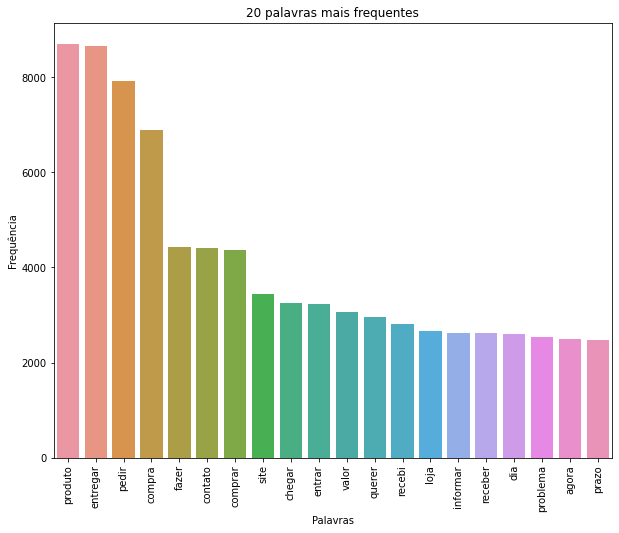

In [82]:
plot_frequency_barchart(df, 'documents', f'processed_v1_frequency_{DATASET_VERSION}')

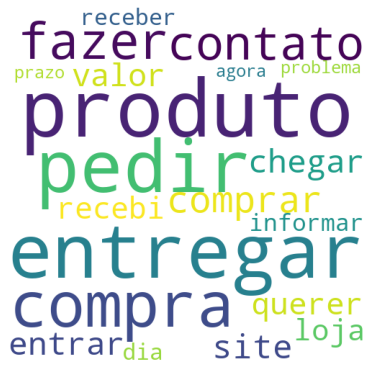

In [83]:
plot_frequency_wordcloud(df, 'documents',  f'processed_wordcloud_{DATASET_VERSION}')

In [85]:
# filter for noun-type 
df['documents_nouns'] = df['documents'].apply(lemmatize_pt, postags=['NOUN'])

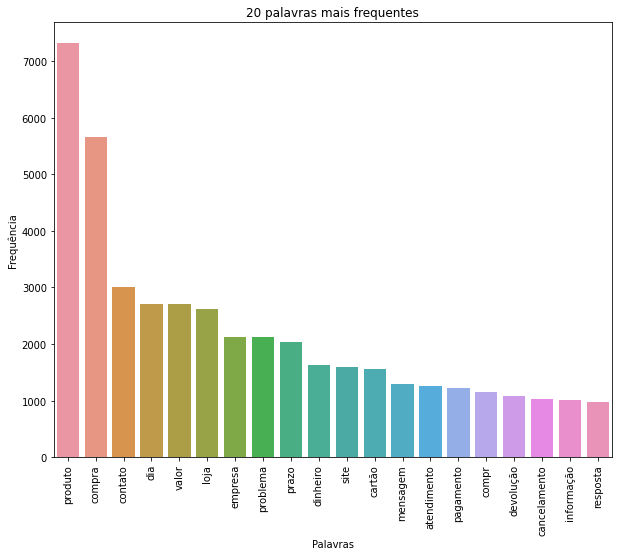

In [86]:
plot_frequency_barchart(df, 'documents_nouns', f'processed_v1_noun_frequency_{DATASET_VERSION}')

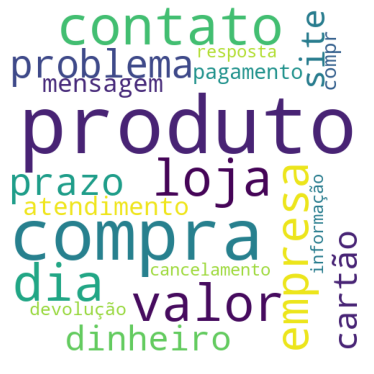

In [87]:
plot_frequency_wordcloud(df, 'documents_nouns',  f'processed__noun_wordcloud_{DATASET_VERSION}')

#### **Pointwise Mutual Information (PMI) score**

Pointwise Mutual Information (PMI) is a measure of association between two events in a statistical model. It is commonly used in natural language processing and information retrieval to measure the degree of association between words or terms in a text. The PMI score of two words w1 and w2 is defined as the logarithm of the ratio of the probability of their co-occurrence to the product of their individual probabilities.

**Bigram**

In [88]:
# find bigrams
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents([WORD_TOKENIZER(doc, language='portuguese') for doc in df.documents])

# filter only those that occur at least 20 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [89]:
# save the first 20 bigrams
pd.DataFrame(bigram_scores[:20], 
             columns=['bigram', 'score']).to_csv(
                 os.path.join(WORK_DIR,
                              f'bigram_scores_{DATASET_VERSION}.csv'), 
                              index=False)

In [90]:
# create a bigram column
df['bigrams'] = df['documents'].apply(lambda x: list(nltk.bigrams(x.split())))

# create a noun bigram column 
df['noun_bigrams'] = df['documents_nouns'].apply(lambda x: list(nltk.bigrams(x.split())))

In [91]:
# save bigrams
df.to_csv(os.path.join(WORK_DIR, f'processed_{DATASET_VERSION}.csv'), index=False)

**Wordcloud from bigrams**

In [92]:
def plot_bigram_wordcloud(df, colname, filename):
  # Create a string from the bigrams
  bigrams = df[colname].tolist()
  bigrams = [bigram for sublist in bigrams for bigram in sublist]
  bigrams_string = ' '.join(["_".join(bigram) for bigram in bigrams])
  
  # stop words
  stop_words = nltk.corpus.stopwords.words('portuguese') + custom_stop_words

  # Create the wordcloud
  wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                colormap='viridis',
                min_font_size = 10,
                collocations=False, 
                stopwords = set(stop_words), 
                normalize_plurals=False,
                max_words = 20,
                random_state=1).generate(bigrams_string)

  # Plot the wordcloud
  plt.figure(figsize = (5, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  
  # save figure
  filename = f"{filename}.png"
  plt.savefig(os.path.join(WORK_DIR, filename))
  
  plt.show()

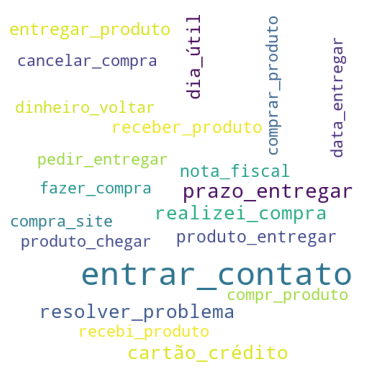

In [93]:
# plot bigram words
plot_bigram_wordcloud(df, 'bigrams', f'bigram_wordcloud_{DATASET_VERSION}')

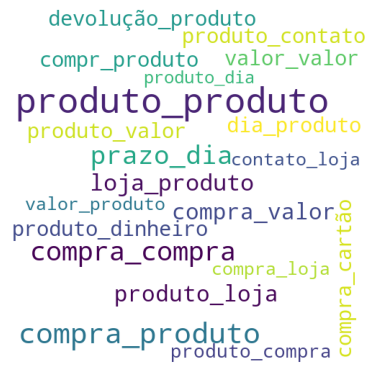

In [94]:
# plot noun bigram words
plot_bigram_wordcloud(df, 'noun_bigrams', f'noun_bigram_wordcloud_{DATASET_VERSION}')

**Trigram**

In [95]:
# find bigrams
trigram_measures = TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_documents([WORD_TOKENIZER(doc, language='portuguese') for doc in df.documents])

# filter only those that occur at least 20 times
finder.apply_freq_filter(20)
trigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [96]:
# save the first 20 trigrams
pd.DataFrame(trigram_scores[:20], 
             columns=['trigram', 'score']).to_csv(
                 os.path.join(WORK_DIR,
                              f'trigram_scores_{DATASET_VERSION}.csv'), 
                              index=False)

In [97]:
# create a trigram column
df['trigrams'] = df['documents'].apply(lambda x: list(nltk.trigrams(x.split())))

# create a noun trigram column
df['noun_trigrams'] = df['documents_nouns'].apply(lambda x: list(nltk.trigrams(x.split())))

In [98]:
# save trigrams
df.to_csv(os.path.join(WORK_DIR, f'processed_{DATASET_VERSION}.csv'), index=False)

**Worcloud from trigrams**

In [99]:
def plot_trigram_wordcloud(df, colname, filename):
  # Create a string from the trigrams
  trigrams = df[colname].tolist()
  trigrams = [bigram for sublist in trigrams for bigram in sublist]
  trigrams_string = ' '.join(["_".join(trigram) for trigram in trigrams])

  # stop words
  stop_words = nltk.corpus.stopwords.words('portuguese') + custom_stop_words

  # Create the wordcloud
  wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                colormap='viridis',
                min_font_size = 10,
                stopwords = set(stop_words),
                collocations=False, 
                normalize_plurals=False,
                max_words = 15,
                random_state=1).generate(trigrams_string)

  # Plot the wordcloud
  plt.figure(figsize = (5, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  
  # save figure
  filename = f"{filename}.png"
  plt.savefig(os.path.join(WORK_DIR, filename))
  
  plt.show()

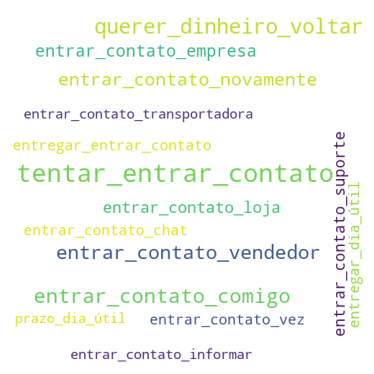

In [100]:
plot_trigram_wordcloud(df, 'trigrams', f'trigram_wordcloud_{DATASET_VERSION}')

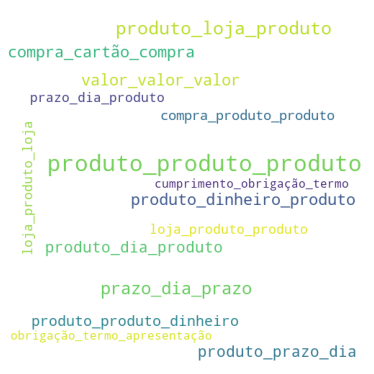

In [101]:
plot_trigram_wordcloud(df, 'noun_trigrams', f'noun_trigram_wordcloud_{DATASET_VERSION}')

#### **Remove any row which contains null value and save final processed data**

In [110]:
df = df.dropna()
df.to_csv(os.path.join(WORK_DIR, f'processed_{DATASET_VERSION}.csv'), index=False)

#### **Github**

In [1]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa
Your public key has been saved in /root/.ssh/id_rsa.pub
The key fingerprint is:
SHA256:xEQn7p3X5BlOIUVeN3fadKmL4U5coWLFCP6vzdfNgmM root@eb124f23fe86
The key's randomart image is:
+---[RSA 4096]----+
|       o= + .o+.O|
|      .+ + o + B*|
|       .+ . . O .|
|       o.+ + O o |
|        S.* = *  |
|          .* .   |
|          o. ....|
|          +.E...o|
|         . +.. . |
+----[SHA256]-----+
# github.com:22 SSH-2.0-babeld-456f9bbd


In [2]:
! cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDB+R6n2LbKX6Ymf2KSaeQWoWPxpKXuOy22lMrrVR1FSESvJHodIEze5xpmj5QWjz/RAcFZgugrSEMKapfOUcl83n3YNkR8rGIiOVYc4U9xz+tyhIbTb3ULBLqL9hX7bk5WjIYFU4bQ1b163NJzTEzqDHK9fsCfCzD4lduThP/Wh7p5cJOgkZDZxrgydcMgTPRnlJIUjh2vp++2xhTMKuuY452YcAfnKmkHBTBxuKKjh07H4hyb+XPAy8fsJbPiaUVZ870ocf0sBkqLzxR//7SsZmCwFRbe3csnTiofsSxTCiKG2MXQyigM1D0hWEXL8Sak3l6uthOp81SjCGQAPmOG/gyzdR3UH/gpm8s0KQLm0xCDQ7LQ+Mk12v1VCj/6tYmET2Qgxw2nBj4gRNf8ItxGOta1yd8ukipCofYGSLjj57e6KQI6Tyoy9zpoU9kxo6T+53hI/MOU73U3/9wF02KCtpTFfnReC0vLlJiBe1E7TUPK0XT2vgnVG419vlnOm74hs+//GLKLOPc8d8DbFu9tbcWf68SXo/3hWUSZMFgYGkIuKFUp1wqGWSFY3s4wCar8Sa+ghsKBDXrjV/Q1gAz5EghcOi8aOAXUuYe7anl3G7VTWZdPgbOPpX8E7nQpKAj1z9xA5TFVaeoHkmpHxttuB2Z1+M2Q1O2wINPxPSlrbw== root@eb124f23fe86


In [3]:
!git config --global user.email "punkmic"
!git config --global user.name "mattheus_ribeiro@outlook.com"

In [4]:
!ssh -T git@github.com

Hi punkmic! You've successfully authenticated, but GitHub does not provide shell access.


In [5]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 16464, done.
remote: Counting objects: 100% (2283/2283), done.
remote: Compressing objects: 100% (1900/1900), done.
remote: Total 16464 (delta 375), reused 2228 (delta 348), pack-reused 14181
Receiving objects: 100% (16464/16464), 149.88 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (1523/1523), done.
Updating files: 100% (14851/14851), done.


In [ ]:
%cd /content/Topic-Modeling-Reclame-Aqui/

/content/Topic-Modeling-Reclame-Aqui


In [112]:
!git add ./datasets/

In [113]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   datasets/bigram_wordcloud_v1.png
	new file:   datasets/frequent_words_removed.csv
	new file:   datasets/noun_bigram_wordcloud_v1.png
	new file:   datasets/noun_trigram_wordcloud_v1.png
	new file:   datasets/processed__noun_wordcloud_v1.png
	new file:   datasets/processed_v1.csv
	new file:   datasets/processed_v1_frequency_v1.png
	new file:   datasets/processed_v1_noun_frequency_v1.png
	new file:   datasets/processed_wordcloud_v1.png



In [114]:
!git commit -m "Updating plots"

[master f7f30b55] Updating plots
 9 files changed, 10421 insertions(+)
 rewrite datasets/bigram_wordcloud_v1.png (99%)
 create mode 100644 datasets/frequent_words_removed.csv
 create mode 100644 datasets/noun_bigram_wordcloud_v1.png
 create mode 100644 datasets/noun_trigram_wordcloud_v1.png
 create mode 100644 datasets/processed__noun_wordcloud_v1.png
 create mode 100644 datasets/processed_v1.csv
 create mode 100644 datasets/processed_v1_frequency_v1.png
 create mode 100644 datasets/processed_v1_noun_frequency_v1.png
 create mode 100644 datasets/processed_wordcloud_v1.png


In [115]:
!git push origin master

Enumerating objects: 13, done.
Counting objects: 100% (13/13), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (10/10), 6.12 MiB | 2.31 MiB/s, done.
Total 10 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:punkmic/Topic-Modeling-Reclame-Aqui.git
   d4b78dd5..f7f30b55  master -> master


In [ ]:
# run this command to push a new version of this notebook in case you have saved the notebook in github and it is outdate 
!git stash
!git pull
!git stash pop

In [ ]:
!rm -rf /root/.ssh/